In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [4]:
import json

import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

import cortex

from src.settings import TrainerSetting

from src.utils.utils import get_surface_dict, put_values_on_mask
from src.utils.meta import read_result_meta

from src.utils.plot import (
    config_plotting,
    figsize_dict,
    get_timescale_scalar_mappable,
    plot_timescale_selectivity,
    plot_timescale_flatmap_from_volume
)
from src.utils.weight import process_primal_weight

In [5]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

result_meta_dir = ".temp/result_meta/bling"

result_metric = "r2"

alpha = 0.05

plotting_context='paper'

analysis_name = "timescale_selectivity"

figsize_type = 'full'

is_log = False
is_symmetric = False
is_alpha_mask = False

diff_max_val = 128

In [6]:
subject_ids = ["COL", "GFW", "TYE"]

config_plotting(context=plotting_context)

figsize = figsize_dict[figsize_type]

In [7]:
def get_stats(subject_id: str):
    en_feature_config = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    zh_feature_config = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"
    
    en_trainer_config = f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    zh_trainer_config = f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"

    en_subject_config = f".temp/config/bling/subject/{subject_id}_en.json"
    zh_subject_config = f".temp/config/bling/subject/{subject_id}_zh.json"  

    en_meta_df = read_result_meta(result_meta_dir,
                                    trainer_setting_path=en_trainer_config,
                                    subject_setting_path=en_subject_config,
                                    feature_setting_path=en_feature_config,)

    zh_meta_df = read_result_meta(result_meta_dir,
                                    trainer_setting_path=zh_trainer_config,
                                    subject_setting_path=zh_subject_config,
                                    feature_setting_path=zh_feature_config,)
    
    
    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()
    
    # loading stats
    en_stat = en_config["stats_path"]
    en_stat = np.load(en_stat)

    zh_stat = zh_config["stats_path"]
    zh_stat = np.load(zh_stat)
    
    keyword = f"test_{result_metric}_selectivity_mask"
    p_val_keyword = f"test_p_values_{result_metric}_mask"

    # en_timescale = get_valid_result(en_stat, keyword, metric=result_metric, alpha=alpha)
    # zh_timescale = get_valid_result(zh_stat, keyword, metric=result_metric, alpha=alpha)
    
    en_timescale,_ = put_values_on_mask(
        en_stat[keyword], en_stat[p_val_keyword], alpha=alpha,
    )
    
    zh_timescale,_ = put_values_on_mask(
        zh_stat[keyword], zh_stat[p_val_keyword], alpha=alpha,
    )
    
    
    keyword = f"test_joint_{result_metric}_score_mask"
    
    en_score, _ = put_values_on_mask(
        en_stat[keyword], en_stat[p_val_keyword], alpha=alpha,
    )
    
    zh_score,_ = put_values_on_mask(
        zh_stat[keyword], zh_stat[p_val_keyword], alpha=alpha,
    )
    
    
    if result_metric == "r2":
        en_score = np.maximum(0, np.sqrt(en_score))
        zh_score = np.maximum(0, np.sqrt(zh_score))
    

    return {
        'timescale': {
            'en': en_timescale,
            'zh': zh_timescale
            },
        'score': {
            'en': en_score,
            'zh': zh_score
            },
    }

In [8]:

stats = {}

for id in subject_ids:
    stats[id] = get_stats(id)

In [9]:
def get_max_min(score: np.ndarray):
    temp = score[~np.isnan(score)]
    
    return temp.max(), temp.min()

plotting COL en
item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)


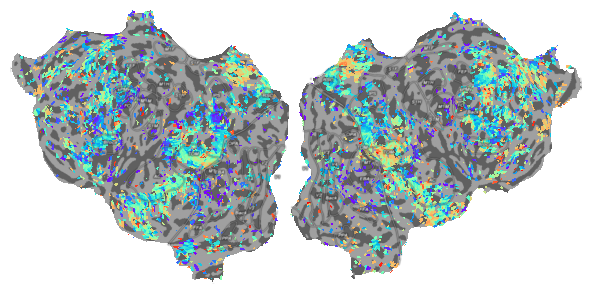

plotting COL zh
item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)


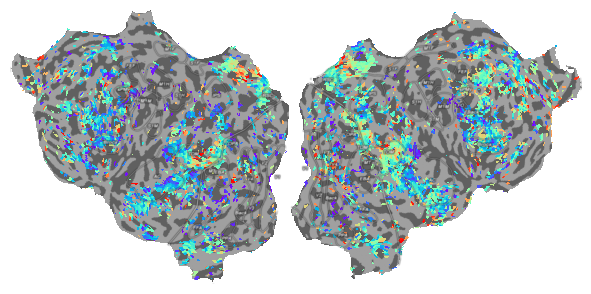

plotting GFW en
Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)


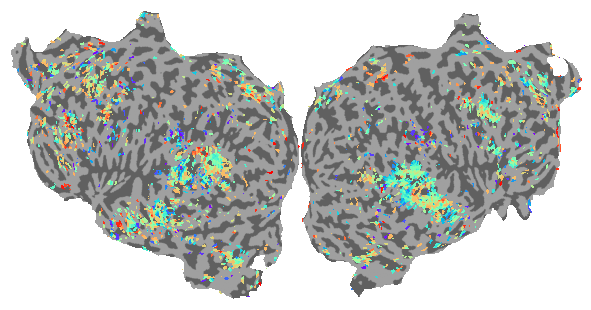

plotting GFW zh
Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)


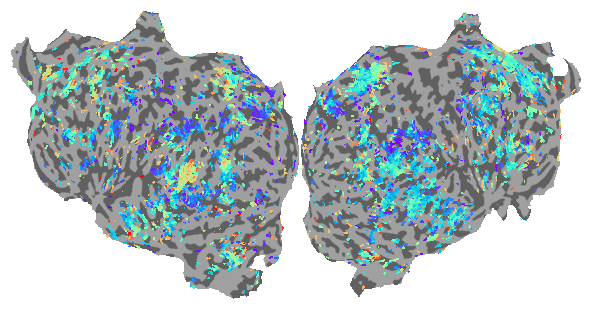

plotting TYE en
Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


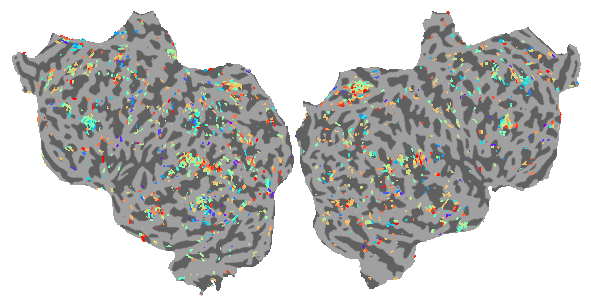

plotting TYE zh
Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


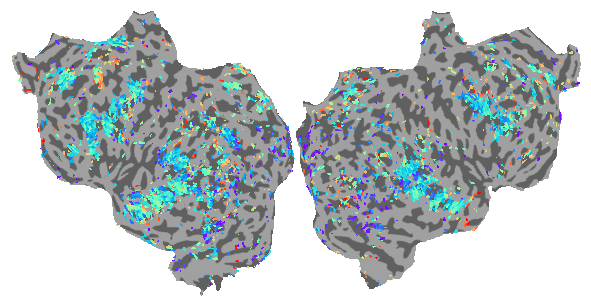

In [10]:
for id in subject_ids:
    surface_dict = get_surface_dict(id)
    for lang in ['en', 'zh']:
        print(f"plotting {id} {lang}")
        
        timescale = stats[id]['timescale'][lang]
        # clip timescale to 8-256
        timescale = np.clip(timescale, 8, 256)
        
        score = stats[id]['score'][lang]
       
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        vol = cortex.Volume(
            timescale,
            surface_dict["surface"],
            surface_dict["transform"],
            cmap="rainbow",
            vmax=256,
            vmin=8,
        )
        
        # plot_timescale_selectivity(
        #     timescale=timescale,
        #     alpha_mask=mask,
        #     surface_dict=surface_dict,
        #     vmin=8,
        #     vmax=256,
        #     cmap='rainbow',
        #     ax = ax,
        #     is_log=is_log,
        #     is_symmetry=is_symmetric
        # )
        
        plot_timescale_flatmap_from_volume(
            vol,
            plot_cbar=False,
            nanmean=True,
            ax=ax
        )
        
        plt.tight_layout()

        save_path=f".temp/image/{analysis_name}/{id}/{lang}_flatmap.png"
        os.makedirs(os.path.dirname(save_path), exist_ok=True) 
        plt.savefig(save_path, dpi=300)
        plt.show()

item_to_outline: fill path has no segments!
item_to_outline: fill path has no segments!
Background RRGGBBAA: ffffff00
Area 0:0:2131.07:1024 exported to 2131 x 1024 pixels (96 dpi)


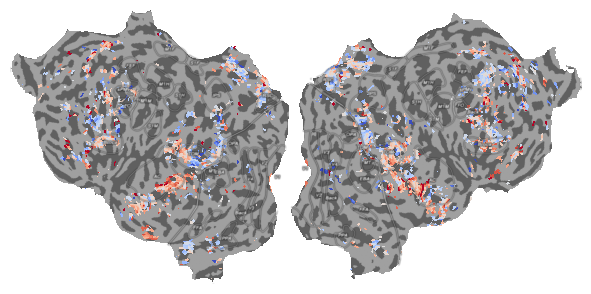

Background RRGGBBAA: ffffff00
Area 0:0:2013.43:1024 exported to 2013 x 1024 pixels (96 dpi)


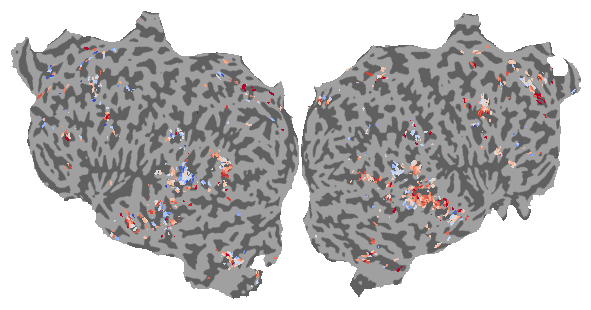

Background RRGGBBAA: ffffff00
Area 0:0:2025.18:1024 exported to 2025 x 1024 pixels (96 dpi)


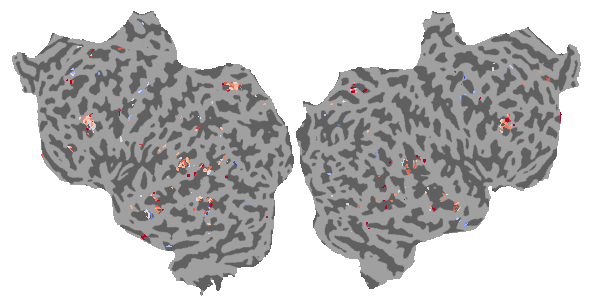

In [11]:
for id in subject_ids:
    surface_dict = get_surface_dict(id)

    timescale_en = stats[id]['timescale']['en']
    
    timescale_zh = stats[id]['timescale']['zh']
    
    diff_timescale = timescale_en - timescale_zh
    
    # calculate percentage positive
    positive_percentage = np.sum(diff_timescale > 0) / np.sum(~np.isnan(diff_timescale))
    
    print(f"{id} positive percentage: {positive_percentage}")
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    vol = cortex.Volume(
        diff_timescale,
        surface_dict["surface"],
        surface_dict["transform"],
        cmap="coolwarm",
        vmin=-diff_max_val,
        vmax=diff_max_val,
    )
    
    plot_timescale_flatmap_from_volume(
        vol,
        plot_cbar=False,
        nanmean=True,
        ax=ax
    )
    
    plt.tight_layout()

    save_path=f".temp/image/{analysis_name}/{id}/diff_flatmap.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True) 
    plt.savefig(save_path, dpi=300)
    plt.show()

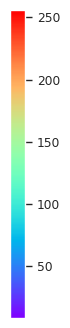

In [12]:
# plot cbar vertical 
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(8, 256)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax)

ax.remove()

save_fn = f".temp/image/{analysis_name}/cbar_vertical.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)

plt.show()

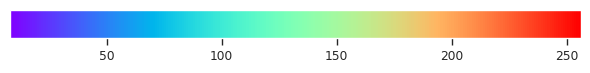

In [13]:
# plot cbar horizontal
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.get_cmap('rainbow')
norm = plt.Normalize(8, 256)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, orientation='horizontal')

ax.remove()

plt.tight_layout()

save_fn = f".temp/image/{analysis_name}/cbar_horizontal.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)

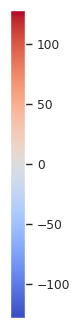

In [14]:
# plot cbar vertical 
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(-diff_max_val, diff_max_val)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax)

ax.remove()

save_fn = f".temp/image/{analysis_name}/cbar_vertical.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)

plt.show()

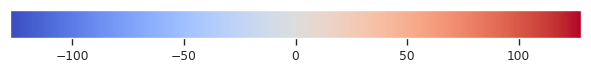

In [15]:
# plot cbar horizontal
fig, ax = plt.subplots(1, 1, figsize=figsize)

cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(-128, 128)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, orientation='horizontal')

ax.remove()

plt.tight_layout()

save_fn = f".temp/image/{analysis_name}/cbar_horizontal.png"

os.makedirs(os.path.dirname(save_fn), exist_ok=True)

plt.savefig(save_fn, dpi=300)